In [ ]:
# Install LGBM

!pip install lightgbm


In [ ]:
# Import relevant libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost
import sklearn
from google.colab import files
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
import lightgbm as lgb
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
import xgboost as xgb


# Import and inspect dataset

file_path = '/content/encoded_df1 (1).csv'

df1 = pd.read_csv(file_path)

print(df1.head())

print(df1.info())

print(df1.describe())

# Count the number of rows in df1
row_count = df1.shape[0]
print(f"The number of rows in df1 is: {row_count}")

# target variable = successful_sell

   age  b1   b2  c3  c4  c8  dow  employment   i1      i2  ...      i5  \
0   34   1  0.0   0   1 NaN    4           7 -1.8  93.075  ...  5099.1   
1   28   1  0.0   0   1 NaN    3           0 -1.8  92.893  ...  5099.1   
2   55   0  0.0  -1   1 NaN    1           6  1.4  93.918  ...  5228.1   
3   47   1  0.0   0   1 NaN    0           0 -0.1  93.200  ...  5195.8   
4   49   0  0.0  -1   1 NaN    1           0  1.4  93.918  ...  5228.1   

   marriage-status  month  n2   n3   n4        n5  n6  school  successful_sell  
0                0      4   2  530  999  0.001771   0     5.0                0  
1                0      5   1  750  999 -1.673152   0     6.0                1  
2                1      7   3  600  999  0.927946   0     2.0                0  
3                1     11   1  860  999  0.203013   0     6.0                0  
4                1      7   6  620  999  0.990804   0     6.0                0  

[5 rows x 22 columns]
<class 'pandas.core.frame.DataFrame'>
RangeInd

#Train Models

## LGBM

In [ ]:
# Train LGBM

X = df1.drop(columns=['successful_sell'])
y = df1['successful_sell']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

train_data = lgb.Dataset(X_train, label=y_train)
valid_data = lgb.Dataset(X_test, label=y_test)

# Hyperparameters

params = {
    'objective': 'binary',
    'metric': 'binary_error',
    'boosting_type': 'gbdt',
    'num_leaves': 31,
    'learning_rate': 0.05,
    'feature_fraction': 0.9,
    'verbose': -1
}

lgbm_model = lgb.train(
    params=params,
    train_set=train_data,
    valid_sets=[train_data, valid_data],
    valid_names=['train', 'valid'],
    num_boost_round=1000  # Train for 1000 iterations
)

y_pred = lgbm_model.predict(X_test)
y_pred_binary = (y_pred > 0.5).astype(int)

accuracy = accuracy_score(y_test, y_pred_binary)
print(f"Accuracy: {accuracy:.2f}")
print("Classification Report - LGBM:")
print(classification_report(y_test, y_pred_binary))


Accuracy: 0.90
Classification Report - LGBM:
              precision    recall  f1-score   support

           0       0.91      0.98      0.94      7310
           1       0.58      0.27      0.37       928

    accuracy                           0.90      8238
   macro avg       0.75      0.62      0.66      8238
weighted avg       0.88      0.90      0.88      8238



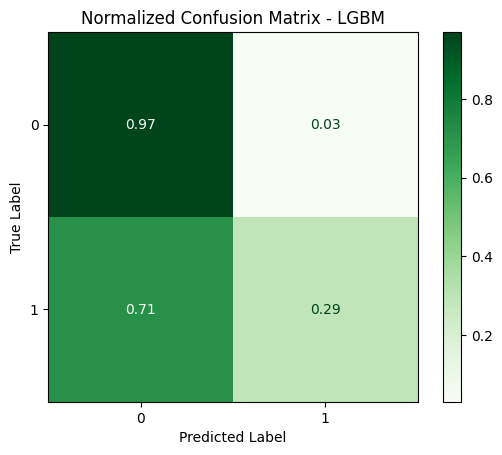

In [ ]:
# Generate confusion matrix

y_pred_binary = (y_pred > 0.5).astype(int)

cm = confusion_matrix(y_test, y_pred_binary, normalize='true')

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
disp.plot(cmap='Blues')

plt.title('Normalized Confusion Matrix - LGBM')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()


In [ ]:
# Perform GridSearch to find better hyperparameters

param_grid = {
    'num_leaves': [31, 50],
    'learning_rate': [0.01, 0.1],
    'n_estimators': [100, 500],
    'max_depth': [-1, 10],
    'min_child_samples': [20, 50],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

grid_search = GridSearchCV(
    estimator=lgb.LGBMClassifier(),
    param_grid=param_grid,
    scoring='f1',
    cv=3,  # 3-fold cross-validation
    verbose=1,
    n_jobs=-1
)

grid_search.fit(X_train, y_train)

print("Best Hyperparameters:", grid_search.best_params_)

best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

print("Classification Report - LGBM with GridSearch:")
print(classification_report(y_test, y_pred))


Fitting 3 folds for each of 128 candidates, totalling 384 fits


/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(


Best Hyperparameters: {'colsample_bytree': 1.0, 'learning_rate': 0.1, 'max_depth': 10, 'min_child_samples': 50, 'n_estimators': 100, 'num_leaves': 50, 'subsample': 0.8}
Classification Report - LGBM with GridSearch:
              precision    recall  f1-score   support

           0       0.91      0.98      0.94      7310
           1       0.59      0.27      0.37       928

    accuracy                           0.90      8238
   macro avg       0.75      0.62      0.65      8238
weighted avg       0.88      0.90      0.88      8238



Fitting 3 folds for each of 50 candidates, totalling 150 fits


/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(


Best Hyperparameters: {'subsample': 1.0, 'num_leaves': 70, 'n_estimators': 200, 'min_child_samples': 50, 'max_depth': 10, 'learning_rate': 0.2, 'colsample_bytree': 1.0}
Classification Report - LGBM with GridSearch:
              precision    recall  f1-score   support

           0       0.91      0.97      0.94      7133
           1       0.55      0.29      0.38       907

    accuracy                           0.89      8040
   macro avg       0.73      0.63      0.66      8040
weighted avg       0.87      0.89      0.88      8040



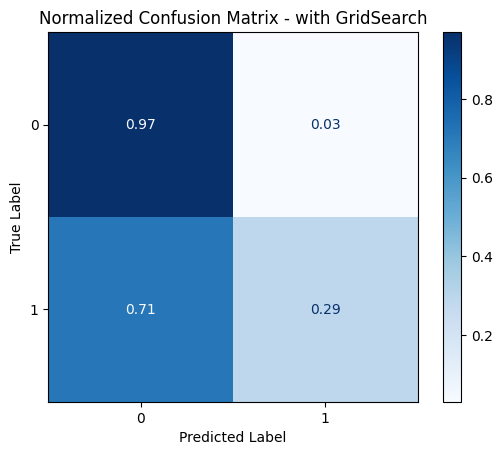

In [ ]:
# Train LGBM with GridSearch

X = df1.drop(columns=['successful_sell'])
y = df1['successful_sell']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

lgbm = lgb.LGBMClassifier()

param_distributions = {
    'num_leaves': [31, 50, 70, 100],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'n_estimators': [100, 200, 500, 1000],
    'max_depth': [-1, 10, 20, 30],
    'min_child_samples': [10, 20, 30, 50],
    'subsample': [0.7, 0.8, 0.9, 1.0],
    'colsample_bytree': [0.7, 0.8, 0.9, 1.0]
}

random_search = RandomizedSearchCV(
    estimator=lgbm,
    param_distributions=param_distributions,
    n_iter=50,
    scoring='f1',  # Focus on F1 score to balance precision and recall
    cv=3,
    verbose=1,
    random_state=42,
    n_jobs=-1
)

random_search.fit(X_train, y_train)

# Best parameters
print("Best Hyperparameters:", random_search.best_params_)

best_model = random_search.best_estimator_
y_pred = best_model.predict(X_test)

print("Classification Report - LGBM with GridSearch:")
print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred, normalize='true')
disp = confusion_matrix(y_test, y_pred, normalize='true')

ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1]).plot(cmap='Blues')
plt.title('Normalized Confusion Matrix - with GridSearch')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()


##XGBoost

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [02:30:37] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.98      0.94      7310
           1       0.62      0.24      0.34       928

    accuracy                           0.90      8238
   macro avg       0.77      0.61      0.64      8238
weighted avg       0.88      0.90      0.88      8238



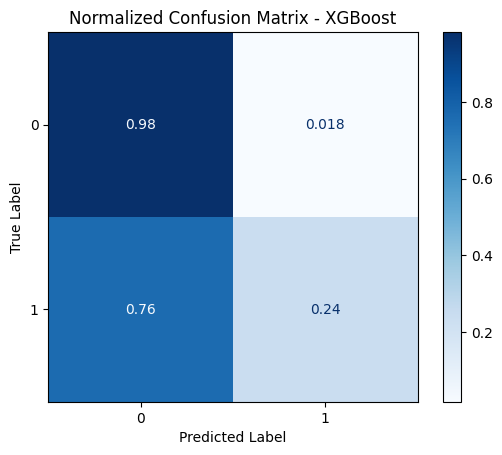

In [ ]:
# Train XGBoost model

X = df1.drop(columns=['successful_sell'])
y = df1['successful_sell']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

xgb_model = xgb.XGBClassifier(
    objective='binary:logistic',
    eval_metric='logloss',
    use_label_encoder=False,
    random_state=42,
    n_estimators=200,
    learning_rate=0.05,
    max_depth=5,
    subsample=0.9,
    colsample_bytree=1.0
)

xgb_model.fit(X_train, y_train)

y_pred = xgb_model.predict(X_test)

print("Classification Report:")
print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred, normalize='true')
disp = confusion_matrix(y_test, y_pred, normalize='true')

ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1]).plot(cmap='Blues')
plt.title('Normalized Confusion Matrix - XGBoost')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()


##Random Forest

Classification Report - Random Forest:
              precision    recall  f1-score   support

           0       0.95      0.89      0.92      7310
           1       0.41      0.61      0.49       928

    accuracy                           0.86      8238
   macro avg       0.68      0.75      0.70      8238
weighted avg       0.89      0.86      0.87      8238



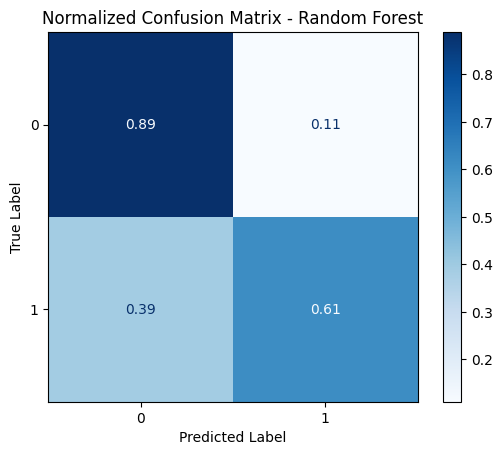

In [ ]:
# Train RandomForest model

X = df1.drop(columns=['successful_sell'])
y = df1['successful_sell']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Hyperparameters

rf_model = RandomForestClassifier(
    n_estimators=200,        # Number of trees
    max_depth=10,            # Maximum depth of the trees
    min_samples_split=10,    # Minimum samples required to split an internal node
    min_samples_leaf=5,      # Minimum samples required to be at a leaf node
    max_features='sqrt',     # Number of features to consider at each split
    random_state=42,         # For reproducibility
    class_weight='balanced'  # To handle class imbalance
)

rf_model.fit(X_train, y_train)

y_pred = rf_model.predict(X_test)

print("Classification Report - Random Forest:")
print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred, normalize='true')
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
disp.plot(cmap='Blues')

plt.title('Normalized Confusion Matrix - Random Forest')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()


##Logistic Regression

In [ ]:
print(X.isna().sum())


age                    0
b1                     0
b2                   990
c3                     0
c4                     0
c8                 35563
dow                    0
employment             0
i1                     0
i2                     0
i3                     0
i4                     0
i5                     0
marriage-status        0
month                  0
n2                     0
n3                     0
n4                     0
n5                     0
n6                     0
school              1731
dtype: int64


In [ ]:
# Count the occurrences of each unique entry in column 'c8'

c8_value_counts = df1['b2'].value_counts(dropna=False)
print(c8_value_counts)


b2
0.0    33950
1.0     6248
NaN      990
Name: count, dtype: int64


In [ ]:
# Handle NaNs

df1['c8'] = df1['c8'].fillna(-1)
df1['school'] = df1['school'].fillna(-1)
df1 = df1.dropna(subset=['b2'])

Classification Report - Logistic Regression:
              precision    recall  f1-score   support

           0       0.95      0.79      0.86      7133
           1       0.29      0.67      0.41       907

    accuracy                           0.78      8040
   macro avg       0.62      0.73      0.64      8040
weighted avg       0.88      0.78      0.81      8040



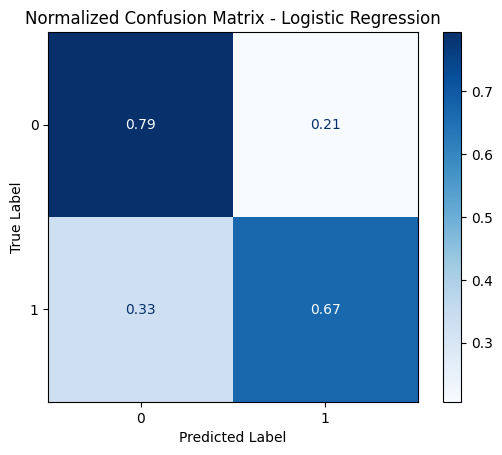

In [ ]:
# Train Logistic Regression model after changes to df1

X = df1.drop(columns=['successful_sell'])
y = df1['successful_sell']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

log_reg_model = LogisticRegression(
    penalty='l2',            # L2 regularization to prevent overfitting
    C=1.0,                   # Inverse of regularization strength
    class_weight='balanced', # Handle class imbalance
    random_state=42,
    solver='liblinear'
)


log_reg_model.fit(X_train, y_train)

y_pred = log_reg_model.predict(X_test)

print("Classification Report - Logistic Regression:")
print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred, normalize='true')
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
disp.plot(cmap='Blues')

plt.title('Normalized Confusion Matrix - Logistic Regression')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

In [ ]:
# Perform GridSearch to find better hyperparameters

# Define parameter grid

param_grid = {'C': [0.01, 0.1, 1, 10, 100], 'penalty': ['l1', 'l2'], 'solver': ['liblinear']}

# Grid search

grid_search = GridSearchCV(LogisticRegression(class_weight='balanced', random_state=42), param_grid, scoring='recall', cv=3)
grid_search.fit(X_train, y_train)

print("Best Hyperparameters:", grid_search.best_params_)

best_log_reg_model = grid_search.best_estimator_


/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1243: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1243: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1243: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1243: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1243: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1243: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  w

Best Hyperparameters: {'C': 0.01, 'penalty': 'l1', 'solver': 'liblinear'}


/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1243: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1243: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Classification Report - Logistic Regression with GridSearch:
              precision    recall  f1-score   support

           0       0.95      0.76      0.85      7133
           1       0.27      0.70      0.39       907

    accuracy                           0.75      8040
   macro avg       0.61      0.73      0.62      8040
weighted avg       0.88      0.75      0.80      8040



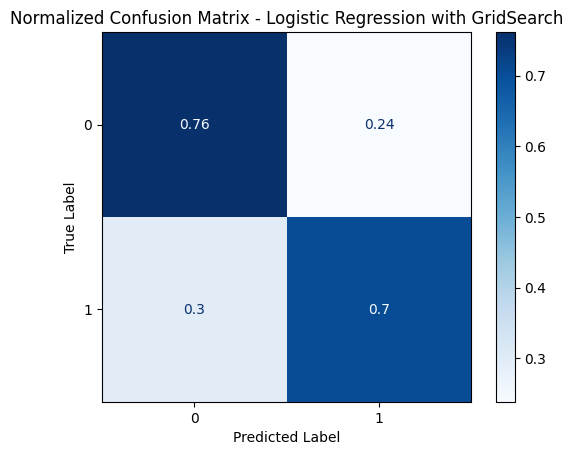

In [ ]:
# Train Logistic Regression model with new hyperparameters

X = df1.drop(columns=['successful_sell'])
y = df1['successful_sell']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Hyperparameters

log_reg_model = LogisticRegression(
    C=0.01,                   # Regularization strength
    penalty='l1',             # L1 regularization for sparsity
    solver='liblinear',       # Solver for L1 penalty
    class_weight='balanced',  # Handle class imbalance
    random_state=42
)

log_reg_model.fit(X_train, y_train)

y_pred = log_reg_model.predict(X_test)

print("Classification Report - Logistic Regression with GridSearch:")
print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred, normalize='true')
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
disp.plot(cmap='Blues')

plt.title('Normalized Confusion Matrix - Logistic Regression with GridSearch')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()


/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1243: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Classification Report - Stacking Classifier:
              precision    recall  f1-score   support

           0       0.91      0.99      0.95      7133
           1       0.69      0.19      0.30       907

    accuracy                           0.90      8040
   macro avg       0.80      0.59      0.62      8040
weighted avg       0.88      0.90      0.87      8040



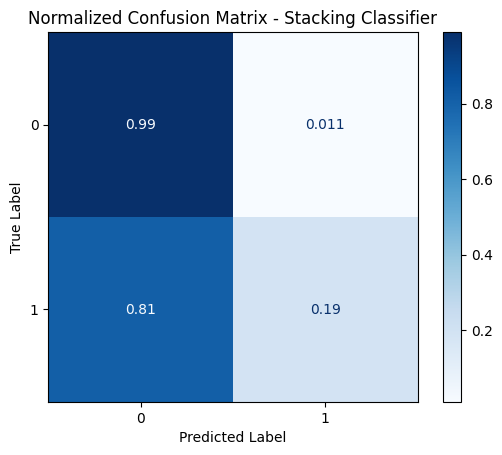

In [ ]:
# Stacking Classifier

rf_model = RandomForestClassifier(
    n_estimators=200, max_depth=10, class_weight='balanced', random_state=42
)

gb_model = GradientBoostingClassifier(
    learning_rate=0.05, n_estimators=200, max_depth=5, random_state=42
)

svc_model = SVC(probability=True, kernel='rbf', C=1.0, random_state=42)

log_reg_meta = LogisticRegression(C=0.01, penalty='l1', solver='liblinear', random_state=42)

stacking_model = StackingClassifier(
    estimators=[('rf', rf_model), ('gb', gb_model), ('svc', svc_model)],
    final_estimator=log_reg_meta,  # Logistic Regression as the meta-classifier
    passthrough=True  # Use original features in addition to predictions
)

stacking_model.fit(X_train, y_train)

y_pred = stacking_model.predict(X_test)

print("Classification Report - Stacking Classifier:")
print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred, normalize='true')
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
disp.plot(cmap='Blues')

plt.title('Normalized Confusion Matrix - Stacking Classifier')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()
